In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Set style for consistent plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [33]:
# Load datasets
file_path = 'QVI_transaction_data.xlsx'
sheet_name = 'in'

transaction_data = pd.read_excel(file_path, sheet_name=sheet_name)

customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

In [34]:
# Print the shape (rows, columns) of the transaction data DataFrame
print("Transaction data shape:", transaction_data.shape)
# Print the shape (rows, columns) of the customer data DataFrame
print("Customer data shape:", customer_data.shape)

Transaction data shape: (264836, 8)
Customer data shape: (72637, 3)


In [35]:
#Examine transaction data structure
print("\nTransaction data info:")
transaction_data.info()


Transaction data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [36]:
## Convert DATE column to date format
# Excel/CSV dates start from 1899-12-30
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

In [37]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [38]:
# Convert suitable columns in transaction_data to categorical data types
transaction_data['STORE_NBR'] = transaction_data['STORE_NBR'].astype('category')
transaction_data['PROD_NBR'] = transaction_data['PROD_NBR'].astype('category')

print("Data types after conversion for transaction_data:")
print(transaction_data.info())

Data types after conversion for transaction_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  category      
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  category      
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 12.9+ MB
None


In [39]:
## Check PROD_NAME values
print("\nTop 10 product names:")
print(transaction_data['PROD_NAME'].value_counts().head(10))


Top 10 product names:
PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
Kettle 135g Swt Pot Sea Salt                3257
Tostitos Splash Of  Lime 175g               3252
Infuzions Thai SweetChili PotatoMix 110g    3242
Smiths Crnkle Chip  Orgnl Big Bag 380g      3233
Thins Potato Chips  Hot & Spicy 175g        3229
Name: count, dtype: int64


In [40]:
transaction_data['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

We found products, such as salsa, that are not chips and therefore must be removed.

In [41]:
##checking the number of salsa and data shape
print("\nNumber of salsa products before removal:",
      transaction_data['PROD_NAME'].str.contains('salsa', case=False).sum())
print("Data shape before removal:", transaction_data.shape)


Number of salsa products before removal: 18094
Data shape before removal: (264836, 8)


In [42]:
#Filtering out salsa and checking product shape after removal
transaction_data = transaction_data[~transaction_data['PROD_NAME'].str.contains('salsa', case=False)]
print("\nNumber of salsa products after removal:",
      transaction_data['PROD_NAME'].str.contains('salsa', case=False).sum())
print("Data shape after removal:", transaction_data.shape)


Number of salsa products after removal: 0
Data shape after removal: (246742, 8)


In [43]:
## Summary statistics to check for outliers
print("\nSummary statistics:")
transaction_data.describe()


Summary statistics:


,DATE,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,246742,2.467420e+05,2.467420e+05,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,1.355310e+05,1.351311e+05,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,2018-09-30 00:00:00,7.001500e+04,6.756925e+04,2.000000,5.800000
50%,2018-12-30 00:00:00,1.303670e+05,1.351830e+05,2.000000,7.400000
75%,2019-03-31 00:00:00,2.030840e+05,2.026538e+05,2.000000,8.800000
max,2019-06-30 00:00:00,2.373711e+06,2.415841e+06,200.000000,650.000000
std,NaN,8.071528e+04,7.814772e+04,0.659831,3.077828


200 has been identified as an outlier in the PROD_QTY column, hence must be removed

In [44]:
#filter out PROD_QTY == 200
transaction_data = transaction_data[transaction_data['PROD_QTY'] != 200]
print("\nSummary statistics after outlier removal:")
transaction_data.describe()


Summary statistics after outlier removal:


,DATE,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,246740,2.467400e+05,2.467400e+05,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,1.355303e+05,1.351304e+05,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,2018-09-30 00:00:00,7.001500e+04,6.756875e+04,2.000000,5.800000
50%,2018-12-30 00:00:00,1.303670e+05,1.351815e+05,2.000000,7.400000
75%,2019-03-31 00:00:00,2.030832e+05,2.026522e+05,2.000000,8.800000
max,2019-06-30 00:00:00,2.373711e+06,2.415841e+06,5.000000,29.500000
std,NaN,8.071520e+04,7.814760e+04,0.342499,2.474897


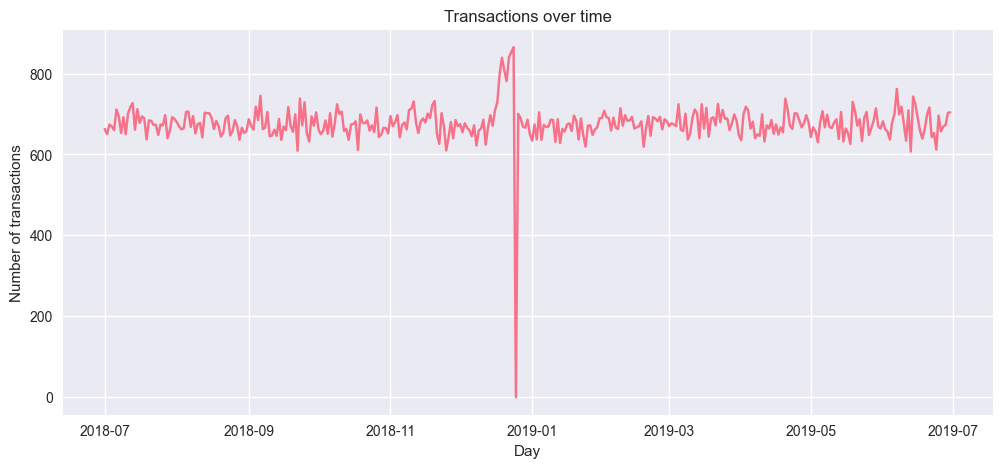


Missing dates: DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq='D')


In [45]:
# Create a reference date range
date_range = pd.date_range(start='2018-07-01', end='2019-06-30')

# Aggregate transactions by date
transactions_by_day = transaction_data.groupby('DATE').size().reindex(date_range, fill_value=0)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(transactions_by_day.index, transactions_by_day.values)
plt.title("Transactions over time")
plt.xlabel("Day")
plt.ylabel("Number of transactions")
plt.show()

# Verification: Print dates with 0 transactions
print("\nMissing dates:", transactions_by_day[transactions_by_day == 0].index)

In [46]:
## Create new features: pack size and brand
# Extract pack size (numbers) from PROD_NAME
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(int)

# Check pack sizes
pack_size_counts = transaction_data['PACK_SIZE'].value_counts().sort_index()
print("\nPack size distribution:")
print(pack_size_counts)


Pack size distribution:
PACK_SIZE
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64


In [47]:
# Extract first word as Brand
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()
unique = transaction_data['BRAND'].unique()
print(unique)
print(f'\nTotal unique brands: {len(unique)}')
transaction_data.nunique()

['NATURAL' 'CCS' 'SMITHS' 'KETTLE' 'GRAIN' 'DORITOS' 'TWISTIES' 'WW'
 'THINS' 'BURGER' 'NCC' 'CHEEZELS' 'INFZNS' 'RED' 'PRINGLES' 'DORITO'
 'INFUZIONS' 'SMITH' 'GRNWVES' 'TYRRELLS' 'COBS' 'FRENCH' 'RRD' 'TOSTITOS'
 'CHEETOS' 'WOOLWORTHS' 'SNBTS' 'SUNBITES']

Total unique brands: 28


DATE                 364
STORE_NBR            271
LYLTY_CARD_NBR     71287
TXN_ID            245255
PROD_NBR             105
PROD_NAME            105
PROD_QTY               5
TOT_SALES            104
PACK_SIZE             20
BRAND                 28
dtype: int64

In [48]:
# Clean Brand Names dictionary
brand_corrections = {
    'RED': 'RRD',
    'SNBTS': 'SUNBITES',
    'INFZNS': 'INFUZIONS',
    'WW': 'WOOLWORTHS',
    'SMITH': 'SMITHS',
    'NCC': 'NATURAL',
    'DORITO': 'DORITOS',
    'GRAIN': 'GRNWVES'
}

transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_corrections)

# Validation
print(transaction_data['BRAND'].value_counts().sort_index())

BRAND
BURGER         1564
CCS            4551
CHEETOS        2927
CHEEZELS       4603
COBS           9693
DORITOS       25224
FRENCH         1418
GRNWVES        7740
INFUZIONS     14201
KETTLE        41288
NATURAL        7469
PRINGLES      25102
RRD           16321
SMITHS        30353
SUNBITES       3008
THINS         14075
TOSTITOS       9471
TWISTIES       9454
TYRRELLS       6442
WOOLWORTHS    11836
Name: count, dtype: int64


In [49]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246740 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246740 non-null  datetime64[ns]
 1   STORE_NBR       246740 non-null  category      
 2   LYLTY_CARD_NBR  246740 non-null  int64         
 3   TXN_ID          246740 non-null  int64         
 4   PROD_NBR        246740 non-null  category      
 5   PROD_NAME       246740 non-null  object        
 6   PROD_QTY        246740 non-null  int64         
 7   TOT_SALES       246740 non-null  float64       
 8   PACK_SIZE       246740 non-null  int64         
 9   BRAND           246740 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 17.7+ MB


In [50]:
## Examine customer data
print("\nCustomer data info:")
print(customer_data.info())
print("\nCustomer data sample:")
print(customer_data.head())


Customer data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Customer data sample:
   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream


In [51]:
# Check LIFESTAGE and PREMIUM_CUSTOMER values
lifestage_counts = customer_data['LIFESTAGE'].value_counts()
print("\nLifestage distribution:")
print(lifestage_counts)


Lifestage distribution:
LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64


In [52]:
premium_counts = customer_data['PREMIUM_CUSTOMER'].value_counts()
print("\nPremium customer distribution:")
print(premium_counts)


Premium customer distribution:
PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64


In [53]:
## Merge transaction data with customer data
data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')

In [54]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in the merged dataset:")
print(missing_values)



Missing values in the merged dataset:
DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


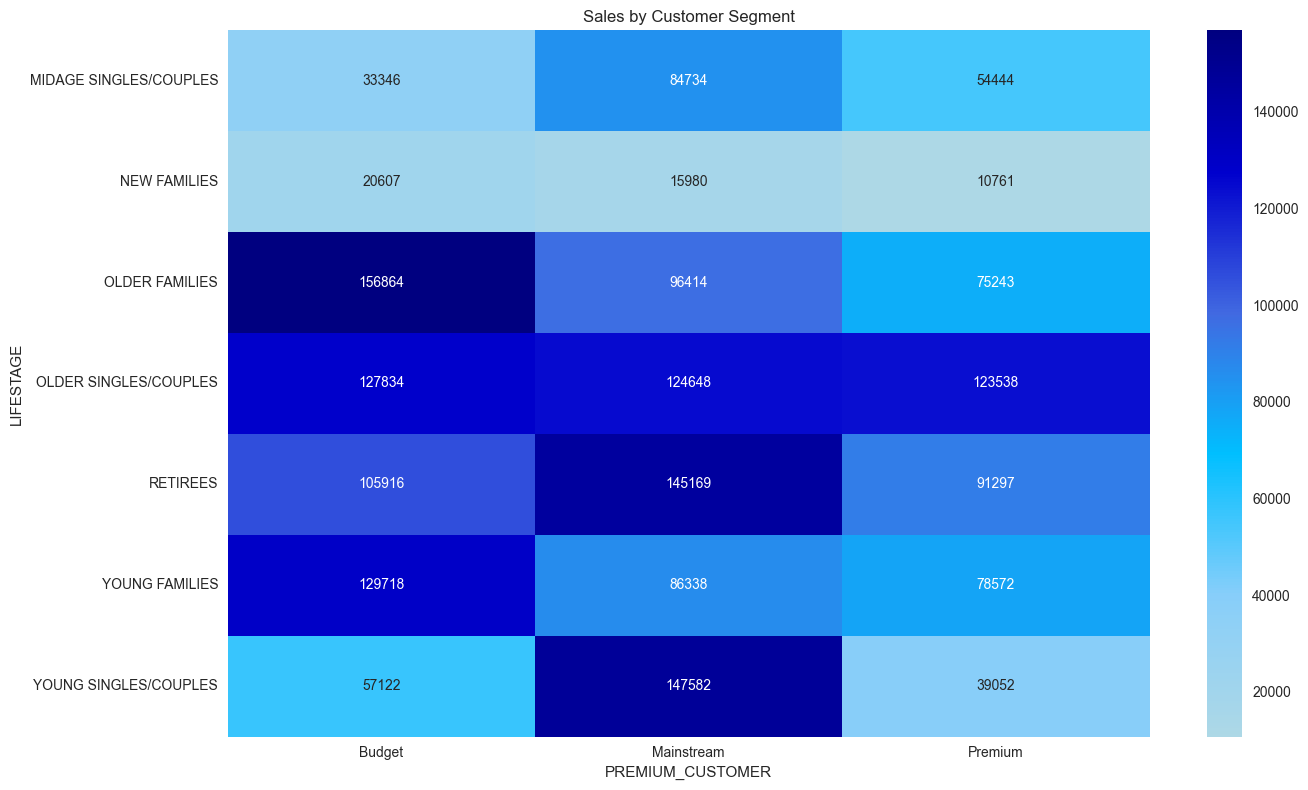

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales = sales.rename(columns={'TOT_SALES': 'SALES'})
sales = sales.sort_values('SALES', ascending=False)

# Plot sales by segment using heatmap
plt.figure(figsize=(14, 8))
pivot_sales = sales.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='SALES')

# Create a custom colormap from navy blue to light blue

colors = ["navy", "mediumblue", "royalblue", "deepskyblue", "lightskyblue", "lightblue"]
cmap = mcolors.LinearSegmentedColormap.from_list("navy_to_lightblue", colors).reversed()

sns.heatmap(pivot_sales, annot=True, fmt='.0f', cmap=cmap)
plt.title('Sales by Customer Segment')
plt.tight_layout()
plt.savefig('sales_by_segment.png')
plt.show()

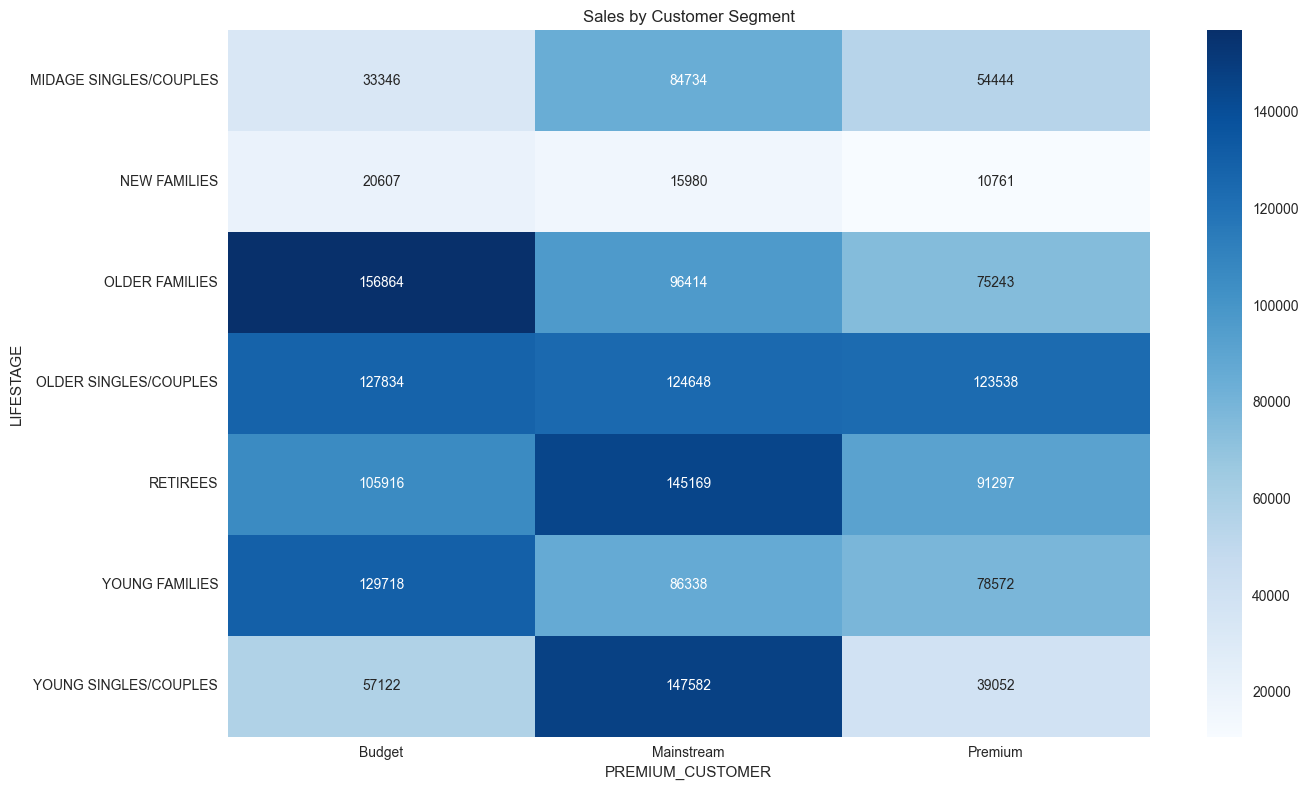

In [56]:
# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales = sales.rename(columns={'TOT_SALES': 'SALES'})
sales = sales.sort_values('SALES', ascending=False)

# Plot sales by segment using heatmap
plt.figure(figsize=(14, 8))
pivot_sales = sales.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='SALES')
sns.heatmap(pivot_sales, annot=True, fmt='.0f', cmap='Blues')
plt.title('Sales by Customer Segment')
plt.tight_layout()
plt.savefig('sales_by_segment.png')
plt.show()

The heatmap above illustrates the total sales generated by different customer segments. We can observe that **Older Families** and **Young Families** across various premium customer categories contribute significantly to total sales. Notably, **Mainstream Young Singles/Couples** also show strong sales performance, highlighting their importance as a target segment.

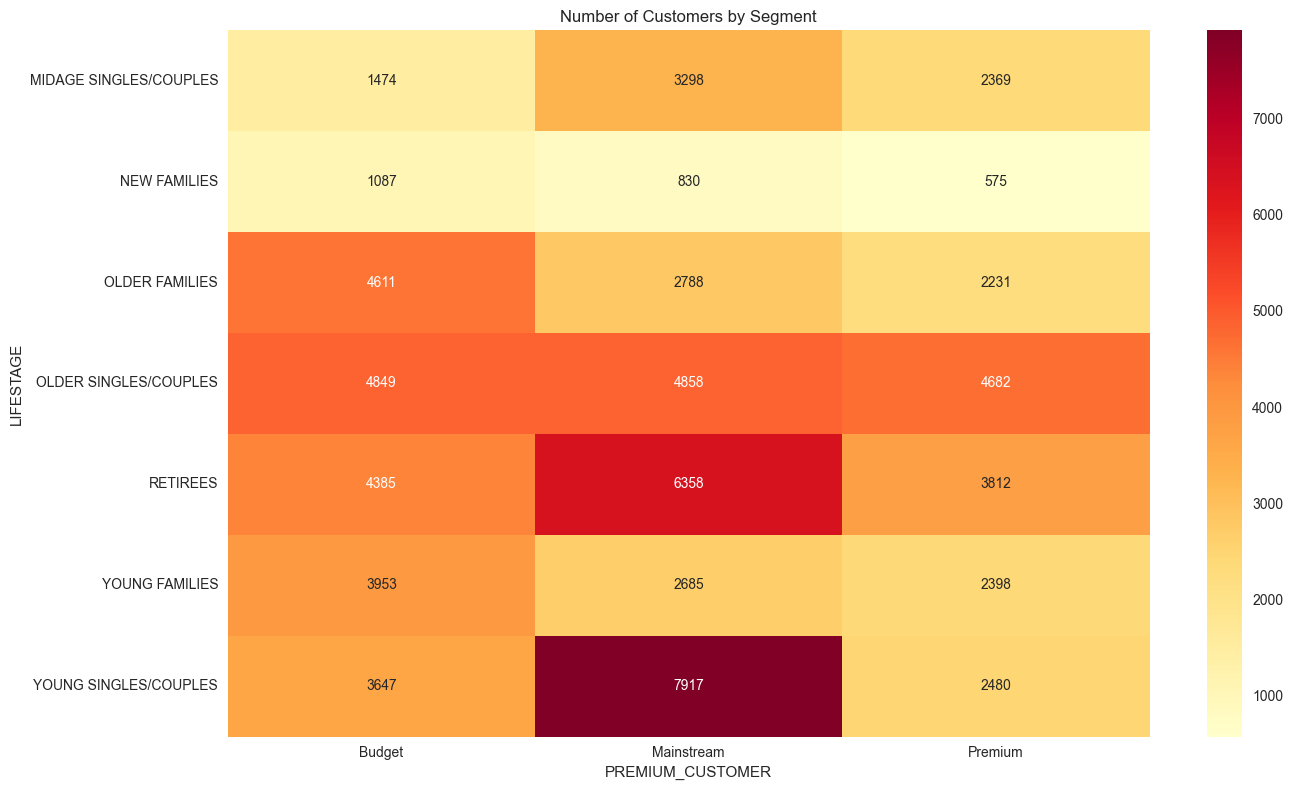

In [57]:
# Number of customers by segment
customers = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customers = customers.rename(columns={'LYLTY_CARD_NBR': 'CUSTOMERS'})
customers = customers.sort_values('CUSTOMERS', ascending=False)

plt.figure(figsize=(14, 8))
pivot_customers = customers.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='CUSTOMERS')
sns.heatmap(pivot_customers, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Customers by Segment')
plt.tight_layout()
plt.savefig('customers_by_segment.png')
plt.show()

The 'Number of Customers by Segment' heatmap provides insight into the customer distribution across different lifestages and premium customer categories. It reveals that **Mainstream Young Singles/Couples** have the highest number of customers, followed by **Mainstream Retirees** and **Budget Older Singles/Couples**. This distribution helps in understanding the reach and penetration within each segment.

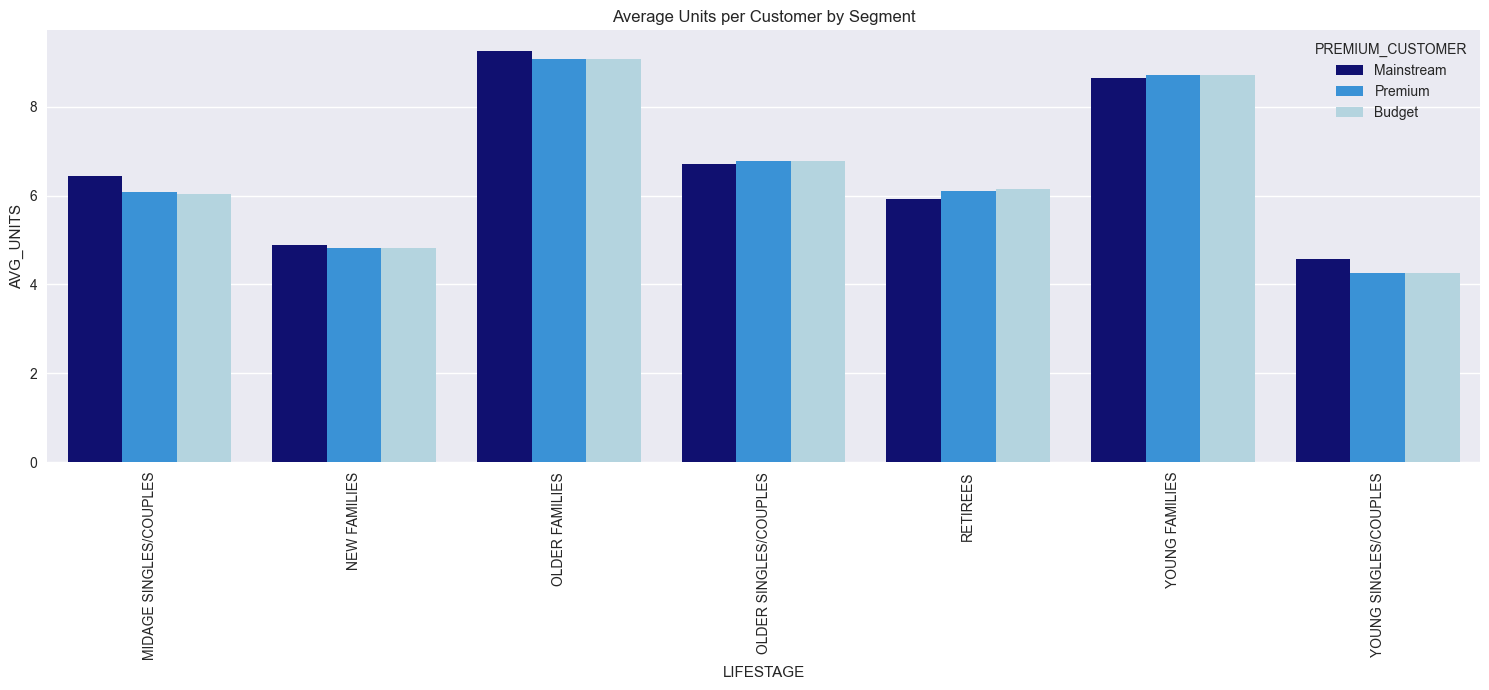

In [61]:
# Average units per customer by segment
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).apply(
    lambda x: x['PROD_QTY'].sum() / x['LYLTY_CARD_NBR'].nunique()
).reset_index(name='AVG_UNITS')

# Sort within each LIFESTAGE group
avg_units = avg_units.sort_values(['LIFESTAGE', 'AVG_UNITS'], ascending=[True, False])

plt.figure(figsize=(15, 7))

# Create custom color palette
colors = ["navy", "mediumblue", "royalblue", "deepskyblue", "lightskyblue", "lightblue"]
cmap = mcolors.LinearSegmentedColormap.from_list("navy_to_lightblue", colors)

# Get unique premium customer categories
premium_categories = avg_units['PREMIUM_CUSTOMER'].unique()
n_categories = len(premium_categories)

# Create a color for each premium category based on its position
# This assumes you have 3 premium customer categories
category_colors = [cmap(i/(n_categories-1)) for i in range(n_categories)]

# Create the barplot with the custom palette
sns.barplot(data=avg_units, x='LIFESTAGE', y='AVG_UNITS', 
            hue='PREMIUM_CUSTOMER', palette=category_colors)

plt.xticks(rotation=90)
plt.title('Average Units per Customer by Segment')
plt.tight_layout()
plt.savefig('units_per_customer.png')
plt.show()

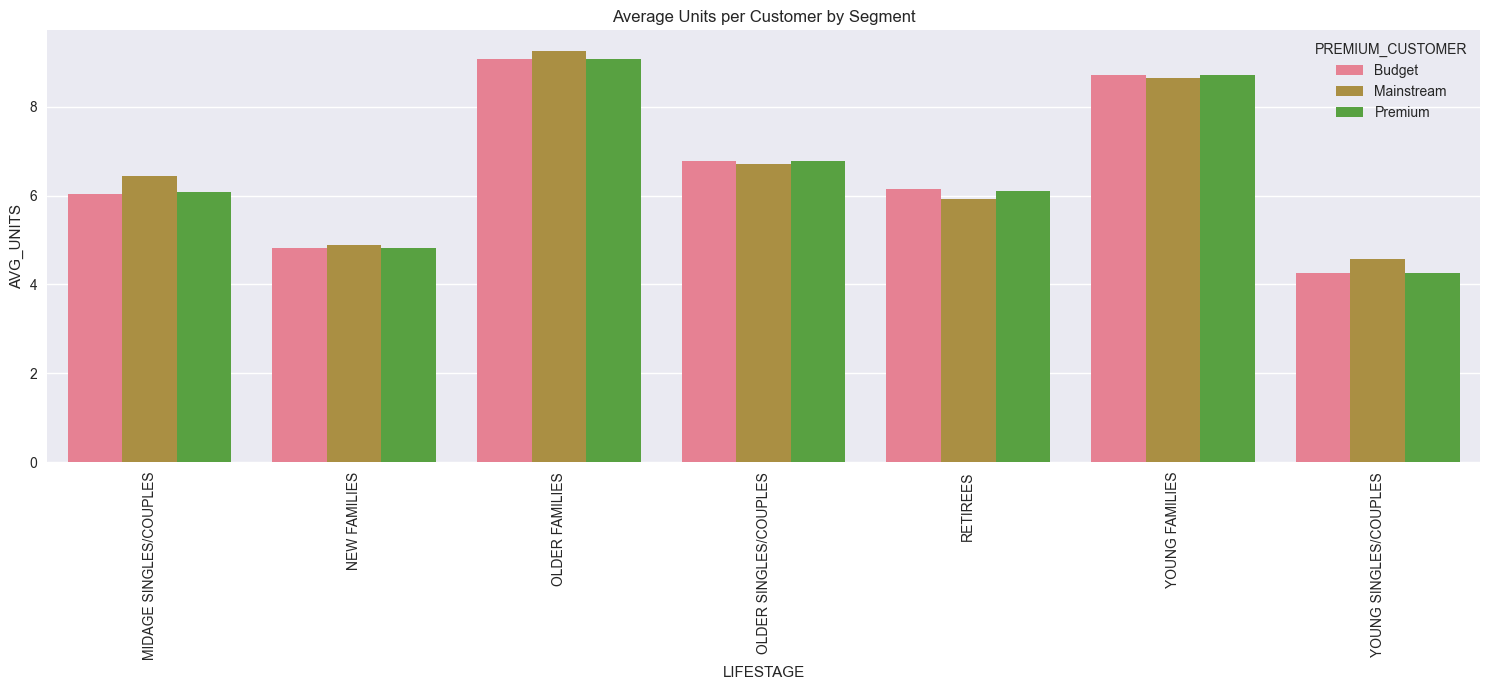

In [27]:
# Average units per customer by segment
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).apply(
    lambda x: x['PROD_QTY'].sum() / x['LYLTY_CARD_NBR'].nunique()
).reset_index(name='AVG_UNITS')

plt.figure(figsize=(15, 7))
sns.barplot(data=avg_units, x='LIFESTAGE', y='AVG_UNITS', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=90)
plt.title('Average Units per Customer by Segment')
plt.tight_layout()
plt.savefig('units_per_customer.png')
plt.show()

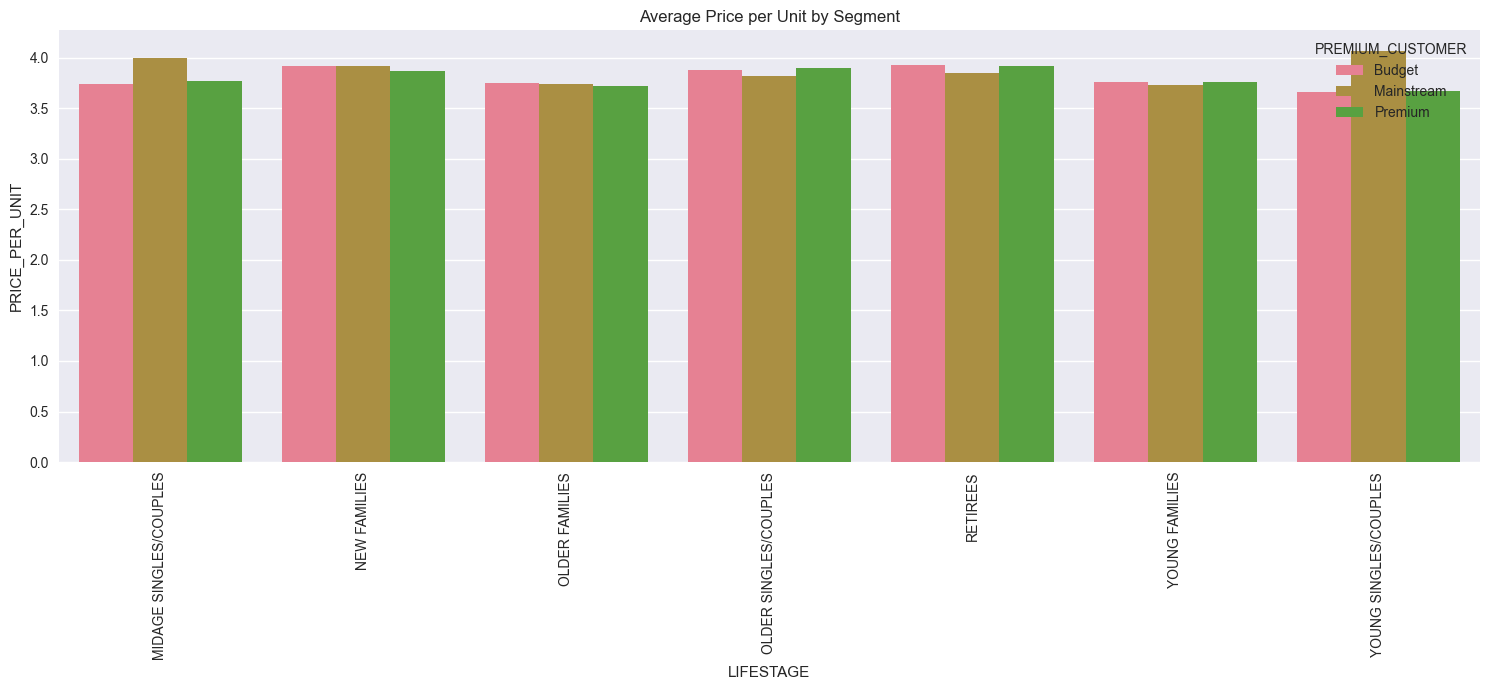

In [28]:

# Average price per unit by segment
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()

plt.figure(figsize=(15, 7))
sns.barplot(data=avg_price, x='LIFESTAGE', y='PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=90)
plt.title('Average Price per Unit by Segment')
plt.tight_layout()
plt.savefig('price_per_unit.png')
plt.show()

This bar chart visualizes the average number of units purchased per customer across different lifestage and premium customer segments. It helps in understanding purchasing habits, indicating which segments tend to buy more items per transaction. For instance, **Older Families** and **Young Families** generally purchase a higher average number of units, suggesting they might be buying in bulk or for larger households.

In [29]:
## Statistical testing for price differences
segment1 = data[(data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
                (data['PREMIUM_CUSTOMER'] == 'Mainstream')]

segment2 = data[(data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
                (data['PREMIUM_CUSTOMER'] != 'Mainstream')]


This bar chart visualizes the average price per unit across different lifestage and premium customer segments. It helps in understanding pricing sensitivity and value perception across various customer groups. For example, some segments might consistently purchase higher-priced items, indicating a preference for premium products, while others might be more budget-conscious.

In [30]:
# Perform t-test
t_stat, p_value = stats.ttest_ind(segment1['PRICE_PER_UNIT'], segment2['PRICE_PER_UNIT'], alternative='greater')
print(f"\nT-test results for price comparison:")
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")


T-test results for price comparison:
T-statistic: 37.8320, p-value: 1.1178e-309


In [31]:
#DEEP DIVE INTO SPECIFIC CUSTOMER SEGMENTS

# Focus on Mainstream young singles/couples
target_segment = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                     (data['PREMIUM_CUSTOMER'] == 'Mainstream')]

other_segments = data[~((data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                       (data['PREMIUM_CUSTOMER'] == 'Mainstream'))]

In [32]:
# Brand affinity analysis
total_qty_target = target_segment['PROD_QTY'].sum()
total_qty_other = other_segments['PROD_QTY'].sum()

brand_target = target_segment.groupby('BRAND')['PROD_QTY'].sum() / total_qty_target
brand_other = other_segments.groupby('BRAND')['PROD_QTY'].sum() / total_qty_other

brand_proportions = pd.DataFrame({
    'target_segment': brand_target,
    'other_segments': brand_other
}).reset_index()
brand_proportions = brand_proportions.sort_values('target_segment', ascending=False)
brand_proportions.head(10)

,BRAND,target_segment,other_segments
9,KETTLE,0.197985,0.165553
5,DORITOS,0.122761,0.101075
11,PRINGLES,0.119420,0.100635
13,SMITHS,0.096370,0.124584
8,INFUZIONS,0.064679,0.057065
15,THINS,0.060373,0.056986
17,TWISTIES,0.046184,0.037877
16,TOSTITOS,0.045411,0.037978
4,COBS,0.044638,0.039049
12,RRD,0.043810,0.067494


In [33]:
# Calculate affinity ratio
brand_proportions['affinity_ratio'] = brand_proportions['target_segment'] / brand_proportions['other_segments']
brand_proportions = brand_proportions.sort_values('affinity_ratio', ascending=False)

print("\nBrand affinity for Mainstream Young Singles/Couples (Top 10):")
print(brand_proportions.head(10))


Brand affinity for Mainstream Young Singles/Couples (Top 10):
        BRAND  target_segment  other_segments  affinity_ratio
18   TYRRELLS        0.031553        0.025692        1.228095
17   TWISTIES        0.046184        0.037877        1.219319
5     DORITOS        0.122761        0.101075        1.214553
9      KETTLE        0.197985        0.165553        1.195897
16   TOSTITOS        0.045411        0.037978        1.195713
11   PRINGLES        0.119420        0.100635        1.186670
4        COBS        0.044638        0.039049        1.143124
8   INFUZIONS        0.064679        0.057065        1.133435
15      THINS        0.060373        0.056986        1.059423
7     GRNWVES        0.032712        0.031188        1.048873


In [34]:
# Pack size preference analysis
pack_target = target_segment.groupby('PACK_SIZE')['PROD_QTY'].sum() / total_qty_target
pack_other = other_segments.groupby('PACK_SIZE')['PROD_QTY'].sum() / total_qty_other

pack_proportions = pd.DataFrame({
    'target_segment': pack_target,
    'other_segments': pack_other
}).reset_index()
pack_proportions = pack_proportions.sort_values('target_segment', ascending=False)
pack_proportions

,PACK_SIZE,target_segment,other_segments
10,175,0.254990,0.270007
6,150,0.157598,0.163421
4,134,0.119420,0.100635
2,110,0.106280,0.089791
9,170,0.080773,0.080986
18,330,0.061284,0.050162
8,165,0.055652,0.062268
19,380,0.032160,0.025584
17,270,0.031829,0.025096
14,210,0.029124,0.025121


In [35]:
# Calculate affinity ratio
pack_proportions['affinity_ratio'] = pack_proportions['target_segment'] / pack_proportions['other_segments']
pack_proportions = pack_proportions.sort_values('affinity_ratio', ascending=False)

print("\nPack size affinity for Mainstream Young Singles/Couples (Top 10):")
print(pack_proportions.head(10))


Pack size affinity for Mainstream Young Singles/Couples (Top 10):
    PACK_SIZE  target_segment  other_segments  affinity_ratio
17        270        0.031829        0.025096        1.268287
19        380        0.032160        0.025584        1.257030
18        330        0.061284        0.050162        1.221717
4         134        0.119420        0.100635        1.186670
2         110        0.106280        0.089791        1.183637
14        210        0.029124        0.025121        1.159318
5         135        0.014769        0.013075        1.129511
16        250        0.014355        0.012781        1.123166
9         170        0.080773        0.080986        0.997370
6         150        0.157598        0.163421        0.964372


In [36]:
# Check brands for 270g packs
print("\nProducts with 270g pack size:")
print(data[data['PACK_SIZE'] == 270]['PROD_NAME'].unique())

## Save final dataset for Task 2
data.to_csv("QVI_data.csv", index=False)
print("\nFinal dataset shape:", data.shape)
print("Dataset saved as QVI_data.csv")


Products with 270g pack size:
['Twisties Cheese     270g' 'Twisties Chicken270g']

Final dataset shape: (246740, 13)
Dataset saved as QVI_data.csv
